<h1>1 Импортирование необходимых модулей, функционала</h1>

In [142]:
import warnings
from tqdm import tqdm_notebook, tqdm
import pickle

import numpy as np
import pandas as pd
from itertools import combinations

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, make_scorer

import shap
import eli5
from eli5.sklearn import PermutationImportance

tqdm.pandas()
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

Версии всех внешних модулей представлены в файле "requirements.txt".

<h1>2 Глобальные параметры</h1>

In [143]:
# Список метрик, на основе которых будем оценивать успешность обучения модели
metrics = [accuracy_score, roc_auc_score]

# Установка значения для генератора псевдослучайных чисел; необходимо для воспроизводимости результатов
SEED = 42

# Ключ для объединения данных разных годов
key = 'customer'

Словарь признаков для конвертации в удобный для работы с ними вид.

In [144]:
overdue_ar_params = {
    'Макс. ПДЗ за год, дней':                        'max_ar',
    'Сред. ПДЗ за год, дней':                        'avg_ar',
    'Кол-во просрочек свыше 5-ти дней за год, шт.':  'ar_count5',
    'Общая сумма ПДЗ свыше 5-ти дней за год, руб.':  'ar_sum',
    'Кол-во раз ПДЗ за год, шт.':                    'ar_count'
}

balance_sections = {
    'Внеоборотные активы':                 'non_current_assets',
    'Нематериальные активы':               'intangible_assets',
    'Основные средства':                   'property_plant_equipment',
    'Оборотные активы':                    'current_assets',
    'Дебиторская задолженность':           'accounts_receivable',
    'Капитал и резервы':                   'capital_and_reserves',
    'Уставный капитал':                    'share_capital',
    'Долгосрочные обязательства':          'non_current_liabilities',
    'Заёмные средства (долгосрочные)':     'nc_borrowings',
    'Краткосрочные обязательства':         'current_liabilities',
    'Заёмные средства (краткосрочные)':    'c_borrowings',
    'Кредиторская задолженность':          'accounts_payable',
    'Выручка':                             'revenue',
    'Себестоимость продаж':                'cost_amount',
    'Прибыль (убыток) от продажи':         'sales_profit',
    'Прибыль (убыток) до налогообложения': 'profit_before_tax'
}

other = {
    'Наименование ДП':                       'customer',
    'Оценка потенциала контрагента 1, руб.': 'score1',
    'Оценка потенциала контрагента 2, руб.': 'score2', 
    'Статус':                                'status',
    'ПДЗ 1-30':                              'oar1_30', 
    'ПДЗ 31-90':                             'oar31_90', 
    'ПДЗ 91-365':                            'oar91_365', 
    'ПДЗ более 365':                         'oar_over365'
}

<h1>3 Разведочный анализ данных</h1>

Создание вспомогательных функций для разведочного анализа данных.

In [145]:
def factor_rename(data, factor:str):
    
    """
    Функция предназначена для конвертации названий факторных признаков в удобный
    для работы с ними вид.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, в которых содержатся требуемые признаки;
    factor: str - название фактора.
    Функция ничего не возвращает; она изменяет названия признаков, которые
    содержатся в переданных ей данных (data).
    """
    
    if isinstance(factor, str):   
            if factor != 'Итого':
                data.rename(columns={factor: 'f{idx}'.format(idx=factor[-2:].strip())}, inplace=True)
            else:
                data.rename(columns={factor: 'Sum'}, inplace=True)
    else:
        raise TypeError('Аргумент "factor" должен принимать строковое значение')

In [146]:
def balance_sections_rename(data, column:str):
    
    """
    Функция предназначена для конвертации названий балансовых признаков в удобный
    для работы с ними вид.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, в которых содержатся требуемые признаки;
    column: str - название балансового признака.
    Функция ничего не возвращает; она изменяет названия балансовых признаков,
    которые содержатся в переданных ей данных (data).
    """
    
    if isinstance(column, str):
        data.rename(columns={column: '{one}{two}'.format(one=balance_sections[column.split(',')[1].strip()],
                                                         two=column.split(',')[0][2:].strip())}, inplace=True)
    else:
        raise TypeError('Аргумент "column" должен принимать строковое значение')

In [147]:
def overdue_ar_params_rename(data, ar_param:str):
    
    """
    Функция предназначена для конвертации названий целевых признаков в удобный
    для работы с ними вид.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, в которых содержатся требуемые признаки;
    ar_param: str - название целевого признака.
    Функция ничего не возвращает; она изменяет названия целевых признаков,
    которые содержатся в переданных ей данных (data).
    """
    
    if isinstance(ar_param, str):
        splitted_col, param = ar_param.split(' '), ''
        for el in splitted_col:
            if not el.isnumeric():
                param += ' ' + el
            else:
                year = el
        data.rename(columns={ar_param: '{one}{two}'.format(one=overdue_ar_params[param.strip()], two=year[2:])},
                    inplace=True)
    else:
        raise TypeError('Аргумент "ar_param" должен принимать строковое значение')

In [148]:
def features_rename(data, columns):
    
    """
    Функция предназначена для переименования признаков в удобный для работы с ними вид.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, в которых содержатся требуемые признаки;
    columns: list - список признаков, которые необходимо переименовать.
    Функция ничего не возвращает; она изменяет названия признаков, которые содержатся
    в переданных ей данных (data).
    """
    
    if isinstance(columns, list):
        for col in tqdm_notebook(columns):
            if col in list(other.keys()):
                data.rename(columns={col: other[col]}, inplace=True)
            elif ('Факт' in col) | ('Итого' in col):
                factor_rename(data, col)
            elif col[0].isnumeric():
                balance_sections_rename(data, col)
            else:
                overdue_ar_params_rename(data, col)
    else:
        raise TypeError('Аргумент "columns" должен быть представлен списком')

In [149]:
def detect_null_data(data, columns):
    
    """
    Функция предназначена для обнаружения пустых наблюдений (строк) в переданных ей данных.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, для которых необходимо найти пустые наблюдения;
    columns: list - список названий признаков (столбцов) данных, которые будут использованы
    для поиска пустых наблюдений.
    Функция возвращает список, содержащий индексы пустых наблюдений.
    """
    
    if isinstance(columns, list):
        null_data = []
        for i in tqdm_notebook(data.index.to_list()):
            sum_ = 0
            current_row = data.loc[i, columns].values
            for j in range(len(current_row)):
                if current_row[j] == 0:
                    sum_ += 1
            if sum_ == len(current_row):
                null_data.append(i)
        print(len(null_data))
        return null_data
    else:
        raise TypeError('Аргумент "columns" должен быть представлен списком')

In [150]:
def factor_filling(data, columns, value=-1):
    
    """
    Функция предназначена для заполнения содержательными значений факторных признаков.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, для которых необходимо заполнить факторные признаки;
    columns: list - список факторных признаков;
    value: int - значение, которым будет замещено некорректное по факторным признакам, 
    значение по умолчанию равно -1.
    Функция ничего не возвращает, она преобразовывает исходные данные (data).
    """
    
    if isinstance(columns, list):
        for col in tqdm_notebook(columns):
            if data[col].isna().sum() != 0:
                data[col].fillna(value, inplace=True)
            else:
                data[col] = data[col].apply(lambda x: -1 if x in ['X', 'Х', 'Н/Д'] else int(x))
    else:
        raise TypeError('Аргумент "columns" должен быть представлен списком')

In [151]:
def factor_cleaning(data, columns):
    
    """
    Функция предназначена для фильтрования факторных признаков.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, для которых необходимо отфильтровать факторные признаки;
    columns: list - список факторных признаков.
    Функция ничего не возвращает, она удаляет факторные признаки, в которых объём
    пустых значений, т.е. значений равных -1, равен объёму исходных данных (data).
    """
    
    to_drop = []
    for col in tqdm_notebook(columns):
        if -1 in data[col].value_counts():
            if data[col].value_counts()[-1] == len(data):
                to_drop.append(col)
    data.drop(to_drop, axis=1, inplace=True)
    print(f' Удалено {len(to_drop)}: \n{to_drop}')

In [152]:
def del_high_corr(data, cut_off=0.7):
    
    """
    Функция предназначена для удаления признаков, у которых корреляция выше некоторого порога.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, для которых будет рассчитана матрица корреляций;
    cut_off: float - порог отсечения коррелирующих признаков, значение по умолчанию равно 0.7,
    что в соответствии с таблицей Чеддока соответствует высокой силе корреляционной связи.
    Функция ничего не возвращает, она удаляет признаки, корреляция которых превышает установленный
    порог.
    """
    
    i, to_drop = 0, []
    while True:
        corr_ = data.corr() >= cut_off
        tmp = list(zip(corr_.sum().index, corr_.sum()))
        if tmp[i][1] > 1:
            data.drop(tmp[i][0], axis=1, inplace=True)
            print(f'Признак {tmp[i][0]} был удалён')
        else:
            i +=1
        if data.shape[1] == corr_.sum().values.sum():
            break

In [153]:
def find_unique_columns(columns1, columns2):
    
    """
    Функция предназначена для поиска уникальных значений двух списков признаков.
    Функция принимает следующие параметры:
    columns1: list - первый список признаков;
    columns2: list - второй список признаков.
    Функция возвращает список уникальных признаков.
    """
    
    
    if isinstance(columns1, list) | isinstance(columns2, list):
        cols1, cols2 = set(columns1), set(columns2)
        return list(cols1.difference(cols2))
    else:
        raise TypeError('Аргумент "columns" должен принимать строковое значение')

In [154]:
def remove_empty_factors(data, columns, cut_off=5):
    
    """
    Функция предназначена для удаления факторных признаков, в которых пустые значения превышают
    установленный допустимый порог их содержания.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, для которых будет осуществлён поиск пустых факторных признаков;
    columns: list - список признаков;
    cut_off: float - порог отсечения пустых факторных признаков, значение по умолчанию равно 5.
    Функция ничего не возвращает; она удаляет факторные признаки, в которых пустые значения
    превышают или равны порого отсечения.
    """
    
    if isinstance(columns, list):
        for col in columns:
            if (len(data) - data[col].value_counts()[-1]) <= cut_off:
                print(f'{col} was dropped')
                data.drop(col, axis=1, inplace=True)
    else:
        raise TypeError('Аргумент "columns" должен быть представлен списком')

In [155]:
def check_empty_cols(data, columns, cut_off=0.5):
    
    """
    Функция предназначена для поиск пустых признаков.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, для которых будет осуществлён поиск пустых признаков;
    columns: list - список признаков;
    cut_off: float - порог отсечения пустых признаков, значение по умолчанию равно 0.5.
    Функция возвращает спико признаков, в которых объём пустых значений превышает установленный порог.
    """
    
    drop_params = []
    if isinstance(columns, list):
        for col in columns:
            try:
                val = round(data[col].value_counts()[-1] / len(data), ndigits=5)
                if val > cut_off:
                    print(col, val)
                    drop_params.append(col)
            except KeyError:
                val = round(data[col].value_counts()[0] / len(data), ndigits=5)
                if val > cut_off:
                    print(col, val)
                    drop_params.append(col)
        print(len(drop_params))
        return drop_params
    else:
        raise TypeError('Аргумент "columns" должен быть представлен списком')

In [156]:
def isfact(name):
    
    """
    Функция предназначена для определения по названию - является ли поле "Фактом", или нет.
    Функция принимает следующие параметры:
    name: str - наименование признака;
    Функция возвращает булево значение True - в положительном случае, False - в отрицательном.
    """
    
    lenth = len(name)
    prefix = name[0]
    postfix = name[1:]
    
    if lenth <=3:
        if prefix == 'f':
            if postfix.isdigit():
                return True
    return False

In [157]:
def rename_years(columns, actual_year, diffs):
    
    """
    Функция предназначена для изменения прямого номера года в названии признака, на относительный.
    Функция принимает следующие параметры:
    columns: list/index - список признаков;
    actual_year: int - номер года, относительно которого дклается нумерация;
    diffs: dict - сопоставления цифрового отклонения года в признаке, его постфиксу, который нужно присвоить
    Функция возвращает список полей, в которых признаки с прямым указанием года переименованы
    """
    
    new_columns = []
    for name in columns:
        if not isfact(name):
            tail = name[-2:]
            if tail.isdigit():
                tail = int(tail)
                tail = tail - actual_year
                if tail == 0:
                    name = name[:-2]
                elif tail > 0 or tail < -5:
                    name = name
                else:
                    name = name[:-2] + diffs[tail]
        new_columns.append(name)
    return new_columns

## 3.1 Первичный анализ данных

Чтение данных, переименование признаков в удобный вид.

In [158]:
ag19 = pd.read_csv('agents2019.csv')
ag19.drop('Unnamed: 0', axis=1, inplace=True)
print(f'Размерность ag19: {ag19.shape}')

ag20 = pd.read_csv('agents2020.csv')
print(f'Размерность ag20: {ag20.shape}')

ag21 = pd.read_csv('agents2021.csv')
ag21.drop('Unnamed: 0', axis=1, inplace=True)
print(f'Размерность ag21: {ag21.shape}')

features_rename(ag19, ag19.columns.to_list())
features_rename(ag20, ag20.columns.to_list())
features_rename(ag21, ag21.columns.to_list())

Размерность ag19: (531, 54)
Размерность ag20: (531, 131)
Размерность ag21: (325, 135)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

Для данных 2020 и 2021 годов заполним пропущенные значения факторных признаков содержательными, а после отфильтруем эти признаки.

In [159]:
factor_filling(ag20, ag20.columns[1:62].to_list())
factor_cleaning(ag20, ag20.columns[1:62].to_list())

factor_filling(ag21, ag21.columns[94:131].to_list())
factor_cleaning(ag21, ag21.columns[94:131].to_list())

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

 Удалено 23: 
['f4', 'f6', 'f8', 'f9', 'f10', 'f11', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f26', 'f34', 'f35', 'f36', 'f38', 'f43', 'f44', 'f45', 'f52', 'f53', 'f56']


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

 Удалено 5: 
['f20', 'f21', 'f56', 'f15', 'f16']


Найдём уникальные признаки для данных за 2019 и 2020 годов.

In [160]:
columns19 = find_unique_columns(ag19.columns.to_list(), ag20.columns.to_list())
columns20 = [column[:-2] + '20' for column in columns19]
columns19.append(key)
columns20.append(key)

columns19, columns20

(['avg_ar19', 'ar_count519', 'ar_sum19', 'max_ar19', 'ar_count19', 'customer'],
 ['avg_ar20', 'ar_count520', 'ar_sum20', 'max_ar20', 'ar_count20', 'customer'])

Объединим данные 2019 и 2020 годов.

In [161]:
agents = pd.merge(ag20, ag19.loc[:, columns19], on=key, how='left')

# для экспортирования данных в csv-файл
# agents.to_csv('agents19_20.csv', index=False)

Удалим более ненужные переменные ag19 и ag20, отвечающие за данные 2019 и 2020 годов соответственно.

In [162]:
del([ag19, ag20])

Удалим пустые факторные признаки из данных за 2021 год и данных "agents".

In [163]:
remove_empty_factors(agents, agents.columns[1:38].to_list())
remove_empty_factors(ag21, ag21.columns[94:125].to_list())

f1 was dropped
f5 was dropped
f7 was dropped
f12 was dropped
f13 was dropped
f14 was dropped
f15 was dropped
f16 was dropped
f23 was dropped
f24 was dropped
f25 was dropped
f27 was dropped
f28 was dropped
f32 was dropped
f37 was dropped
f40 was dropped
f41 was dropped
f42 was dropped
f47 was dropped
f48 was dropped
f57 was dropped
f32 was dropped
f23 was dropped
f24 was dropped
f27 was dropped
f28 was dropped
f30 was dropped
f40 was dropped
f41 was dropped
f42 was dropped
f46 was dropped
f48 was dropped
f50 was dropped
f57 was dropped
f37 was dropped
f1 was dropped
f2 was dropped
f7 was dropped
f12 was dropped
f14 was dropped


Признаки "score1", "score2" и "status" среди данных 2019 и 2020 годов отсутствуют, поэтому уберем их и из данных за 2021 год.

In [164]:
drop21 = columns19[:-1] + columns20[:-1] + ['score1', 'score2', 'status']
ag21.drop(drop21, axis=1, inplace=True)
ag21 = ag21.merge(agents[columns20], on='customer', how='left')

Заменим прямые показатели года в данных, на относительные.

In [165]:
diffs = {-1: '_bef_01',
         -2: '_bef_02',
         -3: '_bef_03',
         -4: '_bef_04',
         -5: '_drop'}

agents.columns = rename_years(agents.columns, 20, diffs)
ag21.columns = rename_years(ag21.columns, 21, diffs)

In [166]:
del diffs[-5]
ag21 = ag21[[i for i in ag21.columns if 'drop' not in i]]

Выровняем количество фактов. Оставим только те, которые присутствуют в обоих наборах.

In [167]:
fcolumns20 = set([fact_col for fact_col in agents.columns if isfact(fact_col)])
fcolumns21 = set([fact_col for fact_col in ag21.columns if isfact(fact_col)])
fcolumns20 ^= fcolumns21

print(f'Факторы подготовлены к удалению:\n{fcolumns20}')

Факторы подготовлены к удалению:
{'f2', 'f30', 'f50', 'f46'}


In [168]:
agents.drop(fcolumns20, axis=1, inplace=True)

Пересчитаем сумму признаков

In [169]:
agents['Sum'] = agents[fcolumns21].to_numpy().sum(axis=1, where=agents[fcolumns21] > 0)
ag21['Sum'] = ag21[fcolumns21].to_numpy().sum(axis=1, where=ag21[fcolumns21] > 0)

## 3.2 Анализ балансовых показателей и поиск аномалий

Установка локальных параметров.

In [170]:
# Список, куда будут собраны индексы "странных записей"
nonsense = []

# Постфиксы отношенй по годам
years = [postfix for _, postfix in diffs.items()]

# Имена балансовых полей
bs_cols = [item for _, item in balance_sections.items()]
pl_cols, bs_cols = bs_cols[-4:], bs_cols[:-4]
bs_chapters = ['non_current_assets','current_assets', 'capital_and_reserves',
               'non_current_liabilities', 'current_liabilities']

Вспомогательный локальный функционал.

In [171]:
def all_years_features(prefix, postfix):
    
    """
    Функция формирует список имен признаков по нужным годам из названий необходимых показателей
    Функция принимает следующие параметры:
    preix: list - перечень показателей без указания на год;
    postfix: list - перечень лет;
    Функция возвращает список имен признаков.
    """
    
    index = []
    for i in postfix:
        for j in prefix:
            index.append(j + i)
    return index

In [172]:
def balance_convergence(data, year):
    
    """
    Функция проверяет сходимость баланса (актив = пассиву)
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные для которых необходимо провести проверку;
    year: str - строковое обозначение года в названии признака (postfix);
    Функция возвращает pandas.Series с разницей Актив - Пассив.
    """
        
    active = data[f'non_current_assets{year}'] + data[f'current_assets{year}']
    passive = data[f'capital_and_reserves{year}'] + data[f'non_current_liabilities{year}'] + \
                data[f'current_liabilities{year}']
    
    return np.around(active - passive, 2)

In [173]:
def chapters_convergence(data, year):
    
    """
    Функция проверяет разницу суммы статей раздела баланса и значения суммы самого раздела
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные для которых необходимо провести проверку;
    year: str - строковое обозначение года в названии признака (postfix);
    Функция возвращает pandas.Series с разницей Раздел - Статьи (составляющие этот раздел).
    """
    
    nca = data[f'non_current_assets{year}'] - data[f'intangible_assets{year}'] - data[f'property_plant_equipment{year}'] 
    ca = data[f'current_assets{year}'] - data[f'accounts_receivable{year}']
    car = data[f'capital_and_reserves{year}'] - data[f'share_capital{year}'] 
    ncl = data[f'non_current_liabilities{year}'] - data[f'nc_borrowings{year}']
    cl = data[f'current_liabilities{year}'] - data[f'c_borrowings{year}'] - data[f'accounts_payable{year}']
        
    result = pd.DataFrame({'nca'+year: nca, 
                           'ca'+year: ca, 
                           'car'+year: car, 
                           'ncl'+year: ncl, 
                           'cl'+year: cl})
 
    return np.around(result, 2)

In [174]:
def diff_margins(data, year):
    
    """
    Функция вычисляет разницу между маржинальной прибылью и прибылью продаж
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные для которых необходимо провести проверку;
    year: str - строковое обозначение года в названии признака (postfix);
    Функция возвращает pandas.Series с разницей Маржинальная прибыль - Прибыль продаж.
    """
    
    margin = data[f'revenue{year}'] - data[f'cost_amount{year}']
    diff_sales_profit = margin - data[f'sales_profit{year}']
    
    return diff_sales_profit

### 3.2.1 Баланс

**3.2.1.1 Все балансовые показатели равны нулю**

Все балансовые показатели за все года, равные нулю, означают, что юридического лица все эти годы не существовало. Такая ситуация возможна, только в случае, если контрагент - Индивдуальный предприниматель (об этом - ниже)

In [175]:
columns = all_years_features(bs_cols, years)

agents['BS_sum'] = agents.loc[:, columns].sum(axis=1)
agents['BS_max'] = agents.loc[:, columns].max(axis=1)
agents['BS_min'] = agents.loc[:, columns].min(axis=1)
agents['is_nonsense'] = agents.iloc[:, -3:].sum(axis=1)

agents.loc[agents['is_nonsense'] == 0].iloc[:, -4:]

,BS_sum,BS_max,BS_min,is_nonsense
340,0.0,0.0,0.0,0.0
488,0.0,0.0,0.0,0.0
523,0.0,0.0,0.0,0.0
528,0.0,0.0,0.0,0.0


In [176]:
nonsense += agents[agents['is_nonsense'] == 0].index.to_list()
agents.drop(agents.columns[-4:], axis=1, inplace=True)

**3.2.1.2 Показатели PL все равны нулю**

Эта проверка - специально вставлена сюда (идет следом за проверкой нулевого баланса), чтобы сравнить перечень контрагентов, выделенных ими. Нулевые показатели PL - означают, что деятельность в выбранных периодах не велась. Аналоги PL есть и у ИП.

In [177]:
agents['PL_sum'] = agents.loc[:, columns].sum(axis=1)
agents['PL_max'] = agents.loc[:, columns].max(axis=1)
agents['PL_min'] = agents.loc[:, columns].min(axis=1)
agents['is_nonsense'] = agents.iloc[:, -3:].sum(axis=1)

agents.loc[agents['is_nonsense'] == 0].iloc[:, -4:]

,PL_sum,PL_max,PL_min,is_nonsense
340,0.0,0.0,0.0,0.0
488,0.0,0.0,0.0,0.0
523,0.0,0.0,0.0,0.0
528,0.0,0.0,0.0,0.0


In [178]:
nonsense += agents[agents['is_nonsense'] == 0].index.to_list()
agents.drop(agents.columns[-4:], axis=1, inplace=True)

**3.2.1.3 Баланс не сходится к нулю**

Баланс строится на основе бухгалтерского/управленческого учета, который ведут методом двойной записи. Этот метод подразумевает, что каждая операция отражается по дебету одного счета и кредиту другого. 

Так как аналитические счета строго делятся на активные (отражают движение Актива) и пассивные (отражают движение Пассива), операции, в зависимости от их экономического смысла, можно отразить одним из четырех способов (по отношению к балансу):
- **ДтА - КтП** - Валюта баланса меняется, но **А = П**
- **ДтА - КтА** - Валюта баланса не меняется, **А = П**
- **ДтП - КтА** - Валюта баланса меняется, но **А = П**
- **ДтП - КтП** - Валюта баланса не меняется, **А = П**

Актив всегда будет равен пассиву. Если это не так, значит операция отражена с ошибкой (например - без указания корсчета), или какие-то данные не попали в отчетность. В любом случае - это ненормальная ситуация, ее нужно отсеять.

In [179]:
for year in years:
    agents['bal' + year] = balance_convergence(agents, year)
    
agents['is_nonsense'] = agents.iloc[:, -4:].sum(axis=1)
agents[agents['is_nonsense'] != 0].iloc[:, -5:]

,bal_bef_01,bal_bef_02,bal_bef_03,bal_bef_04,is_nonsense
14,0.00,0.00,0.00,636.94,636.94
16,-0.00,-0.00,-636.94,-0.00,-636.94
17,0.00,0.00,-636.94,0.00,-636.94
19,0.00,-636.94,0.00,0.00,-636.94
22,636.94,636.94,0.00,-636.94,636.94
...,...,...,...,...,...
514,636.94,0.00,0.00,0.00,636.94
519,-636.94,0.00,-0.00,0.00,-636.94
521,-636.94,0.00,-0.00,0.00,-636.94
524,636.94,1273.89,-636.94,-0.00,1273.89


Не очень хочется терять так много данных. Посмотрим сколько останется, если ограничиться 2000 рублей.

In [180]:
agents[(agents['is_nonsense'] > 2000) | (agents['is_nonsense'] < -2000)].iloc[:, -5:]

,bal_bef_01,bal_bef_02,bal_bef_03,bal_bef_04,is_nonsense
387,-0.0,-0.0,16285350.32,0.00,16285350.32
436,0.0,0.0,-263694.27,-92993.63,-356687.90


In [181]:
nonsense += agents[(agents['is_nonsense'] > 2000) | (agents['is_nonsense'] < -2000)].index.to_list()
agents.drop(agents.columns[-5:], axis=1, inplace=True)

**3.2.1.4 Сумма статей больше суммы раздела**

Такая ситуация, тоже связана с ошибками. Раздел баланса агрегирует суммы входящих в него статей, поэтому сумма показателей статей должна равняться показателю содержащего их раздела.

Но, так как отчетность дана в урезаном виде (не все статьи представлены в разделах), проверить мы можем только одну ситуацию: когда суммы представленных статей больше сумм их разделов.

In [182]:
for year in years:
    agents = pd.concat([agents, chapters_convergence(agents, year)], axis=1)

(agents.iloc[:, -20:] < -1).sum()

nca_bef_01     2
ca_bef_01      0
car_bef_01    31
ncl_bef_01     0
cl_bef_01      2
nca_bef_02     3
ca_bef_02      0
car_bef_02    40
ncl_bef_02     3
cl_bef_02      2
nca_bef_03     2
ca_bef_03      0
car_bef_03    34
ncl_bef_03     3
cl_bef_03      3
nca_bef_04     3
ca_bef_04      0
car_bef_04    30
ncl_bef_04     2
cl_bef_04      6
dtype: int64

Как видно, такой ошибкой страдает, в большинстве случаев, раздел  "capital and reserves". Пройдемся по всем 4 периодам и уберем таких контрагентов. Предположительно, что когда это сделаем, в других разделах ошибки тоже уйдут, но, на всякий случай, пробежимся по всем.

In [183]:
for i in agents.iloc[:, -20:].columns:
    nonsense += agents.loc[agents[i] < -1, :].index.to_list()
agents.drop(agents.columns[-20:], axis=1, inplace=True)

**3.2.1.5 Уставный капитал**

Уставный капиталл - один из важнейших показателей. Без него, по законодательству, нельзя создать юридическое лицо. 
Из этого можно заключить, что по этой статье, у действующего контрагента, эта статья не может равняться 0. Любая другая статья может, а эта - нет. Отрицательного значения - тоже не может быть.

Опустим, что, по законодательству, УК не может быть ниже 10 тыс руб, и наличие таких значений, спишем на предобработку данных для анонимизации контрагентов.

In [184]:
columns = all_years_features(['share_capital', ], years)

(agents[columns] <= -0).sum()

share_capital_bef_01     66
share_capital_bef_02     73
share_capital_bef_03    124
share_capital_bef_04    131
dtype: int64

Те нули, которые нашлись, не обязательно связаны с ошибками. Возможно, что юрлицо, в тот период, еще не существовало (а динамика подсказывает именно это). Тем не менее - записи с такими пропусками, для моделирования, лучше убрать.

In [185]:
for i in columns:
    nonsense += agents.loc[agents[i] <= 0, :].index.to_list()

### 3.2.2 Отчёт о прибылях и убытках

Прежде всего, проверим выручку и себестоимость. Нулевая выручка, при ненулевой себестоимости (и наоборот) - явная ошибка в отчетности. Нули по всем периодам - так же свидетельство об отсутствии операционной деятельности. По разным причинам: от нахождения в фазе инвест-периода, до "только-только регистрации". 

Истории по таким контрагентам нет, поэтому - нет и материала для анализа.

**3.2.2.1 Нулевая выручка во всех периодах**

In [186]:
columns = all_years_features(['revenue',], years)
agents['is_nonsense'] = agents[columns].sum(axis=1)
agents.loc[agents['is_nonsense'] <= 0, columns]

,revenue_bef_01,revenue_bef_02,revenue_bef_03,revenue_bef_04
69,0.0,0.0,0.0,0.0
340,0.0,0.0,0.0,0.0
488,0.0,0.0,0.0,0.0
520,0.0,0.0,0.0,0.0
523,0.0,0.0,0.0,0.0
528,0.0,0.0,0.0,0.0


In [187]:
nonsense += agents.loc[agents['is_nonsense'] <= 0, :].index.to_list()
agents.drop(agents.columns[-1:], axis=1, inplace=True)

**3.2.2.2 Нулевая себестоимость во всех периодах**

In [188]:
columns = all_years_features(['cost_amount',], years)
agents['is_nonsense'] = agents[columns].sum(axis=1)
agents.loc[agents['is_nonsense'] <= 0, columns]

,cost_amount_bef_01,cost_amount_bef_02,cost_amount_bef_03,cost_amount_bef_04
69,0.0,0.0,0.0,0.0
340,0.0,0.0,0.0,0.0
488,0.0,0.0,0.0,0.0
520,0.0,0.0,0.0,0.0
523,0.0,0.0,0.0,0.0
528,0.0,0.0,0.0,0.0


In [189]:
nonsense += agents.loc[agents['is_nonsense'] <= 0, :].index.to_list()
agents.drop(agents.columns[-1:], axis=1, inplace=True)

**3.2.2.3 Соотношение маржинальной прибыли и прибыли с продаж**

В структуре отчета о финансовых результатах, между маржинальной прибылью и прибылью от продаж нет доходной части, поэтому, первая - всегда должна быть выше второй.

In [190]:
for year in years:
    agents['diff_sp_' + year] = diff_margins(agents, year)
    
(agents.iloc[:, -4:] < -1).sum()

diff_sp__bef_01    0
diff_sp__bef_02    0
diff_sp__bef_03    0
diff_sp__bef_04    0
dtype: int64

А здесь - все в порядке

In [191]:
agents.drop(agents.columns[-4:], axis=1, inplace=True)

### 3.2.3 Заключение раздела

По итогам этого раздела, в отчетности следующих контрагентов, есть нестыковки, ошибки или отсутствующие данные.

При условии, что по юрлицу есть история и, что бухгалтерская отчетность - открытая информация, такого быть не должно. 

Если же контрагент не вел операционную деятельность, в каком-то из прошлых периодов, или во всех сразу, информация по такому контрагенту - не полная. Т.к. сейчас, на этапе предварительной очистки данных, еще неизвестно, какие признаки окажутся важными для моделирования - такие пропуски стоит удалить.

Вот полный перечень удаляемых записей\*:

In [192]:
drop_list = [i for i in set(nonsense)]
print(drop_list)
print('\nВсего их -', len(drop_list))

[515, 516, 519, 520, 8, 522, 523, 524, 525, 528, 530, 27, 34, 37, 41, 43, 52, 53, 57, 58, 60, 61, 62, 66, 68, 69, 70, 71, 78, 83, 105, 106, 118, 119, 124, 125, 126, 128, 141, 142, 146, 149, 152, 153, 155, 159, 162, 163, 164, 165, 167, 172, 178, 179, 181, 182, 185, 188, 190, 191, 193, 194, 195, 196, 203, 204, 206, 207, 208, 209, 212, 215, 216, 217, 218, 219, 220, 221, 222, 224, 226, 227, 228, 229, 231, 232, 236, 238, 239, 240, 242, 243, 244, 245, 247, 248, 251, 257, 259, 261, 264, 266, 267, 269, 271, 273, 275, 279, 282, 283, 284, 285, 286, 288, 294, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 307, 308, 310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 322, 324, 325, 326, 328, 330, 333, 340, 343, 355, 356, 361, 367, 368, 372, 373, 375, 376, 384, 386, 387, 389, 391, 397, 402, 406, 418, 426, 429, 430, 436, 438, 439, 441, 442, 443, 444, 447, 448, 449, 450, 452, 457, 459, 460, 461, 462, 463, 465, 466, 467, 468, 469, 471, 475, 476, 477, 479, 482, 483, 484, 486, 487, 488, 489, 490, 493, 

*|\*это при условии того, что по сходимости баланса забракованы не все*

---
Удалим их из данных всех лет:

In [193]:
agents.drop(drop_list, inplace=True)
agents.shape

(318, 88)

In [194]:
drop_list = ag21.loc[ag21['customer'].isin(drop_list)].index.to_list()
ag21.drop(drop_list, inplace=True)
ag21.shape

(189, 87)

<h1>4 Генерация новых признаков</h1>

Вспомогательные функции этого раздела.

In [195]:
def nan_inf(data):
    
    """
    Функция предназначена для замещения бесконечных значений NaN'ами, которые потом
    замещаются нулевыми значениями.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные.
    Функция ничего не возвращает; она выполняет преобразования, описанные выше.
    """
    
    data.replace([np.inf, -np.inf], np.NaN, inplace=True)
    data.fillna(0, inplace=True)

In [196]:
def calculate_ktl(data, year, mask):
    
    """
    Функция предназначена для расчёта коэффициента текущей ликвидности.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан коэффициент;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    
    data[f'ktl{year}'] = np.NaN
    pass_sum = data[f'accounts_payable{year}'] + data[f'c_borrowings{year}']
    data.loc[mask, f'ktl{year}'] = data.loc[mask, f'current_assets{year}'] / pass_sum[mask]
    
    
    nan_inf(data[f'ktl{year}'])

In [197]:
def calculate_owc(data, year, mask):
    
    """
    Функция предназначена для расчёта собственных оборотных средств.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'OWC{year}'] = np.NaN
    data.loc[mask, f'OWC{year}'] = data.loc[mask, f'capital_and_reserves{year}'] -\
                                   data.loc[mask, f'non_current_assets{year}']
    
    nan_inf(data[f'OWC{year}'])

In [198]:
def calculate_cwc(data, year, mask):
    
    """
    Функция предназначена для расчёта чистого оборотного капитала.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'CWC{year}'] = np.NaN
    data.loc[mask, f'CWC{year}'] = data.loc[mask, f'current_assets{year}'] - data.loc[mask, f'current_liabilities{year}']
    nan_inf(data[f'CWC{year}'])

In [199]:
def calculate_wc(data, year, mask):
    
    """
    Функция предназначена для расчёта рабочего капитала.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'WC{year}'] = np.NaN
    data.loc[mask, f'WC{year}'] = data.loc[mask, f'OWC{year}'] + data.loc[mask, f'CWC{year}']
    nan_inf(data[f'WC{year}'])

In [200]:
def calculate_kfn(data, year, mask, balance):
    
    """
    Функция предназначена для расчёта коэффициента финансовой независимости.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса;
    balance: float - значение расситанного ранее баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'kfn{year}'] = np.NaN
    data.loc[mask, f'kfn{year}'] = data.loc[mask, f'capital_and_reserves{year}'] / balance
    nan_inf(data[f'kfn{year}'])

In [201]:
def calculate_kfu(data, year, mask, balance):
    
    """
    Функция предназначена для расчёта коэффициента финансовой устойчивости.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса;
    balance: float - значение расситанного ранее баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'kfu{year}'] = np.NaN
    data.loc[mask, f'kfu{year}'] = (data.loc[mask, f'capital_and_reserves{year}'] +\
                                    data.loc[mask, f'non_current_liabilities{year}']) / balance
    nan_inf(data[f'kfu{year}'])

In [202]:
def calculate_kfl(data, year, mask):
    
    """
    Функция предназначена для расчёта финансового левериджа.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'kfl{year}'] = np.NaN
    data.loc[mask, f'kfl{year}'] = (data.loc[mask, f'non_current_liabilities{year}'] +\
                                    data.loc[mask, f'current_liabilities{year}']) /\
                                    data.loc[mask, f'capital_and_reserves{year}']
    nan_inf(data[f'kfl{year}'])

In [203]:
def calculate_km(data, year, mask):
    
    """
    Функция предназначена для расчёта коэффициента манёвренности.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'km{year}'] = np.NaN
    data.loc[mask, f'km{year}'] = data.loc[mask, f'OWC{year}'] / data.loc[mask, f'capital_and_reserves{year}']
    nan_inf(data[f'km{year}'])

In [204]:
def calculate_kows(data, year, mask):
    
    """
    Функция предназначена для расчёта коэффициента обеспеченности собственными
    основными средствами.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'kows{year}'] = np.NaN
    data.loc[mask, f'kows{year}'] = data.loc[mask, f'OWC{year}'] / data.loc[mask, f'current_assets{year}']
    nan_inf(data[f'kows{year}'])

In [205]:
def calculate_roa_ncl(data, year, mask):
    
    """
    Функция предназначена для расчёта рентабельности внеоборотных активов.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'ROA_ncl{year}'] = np.NaN
    data.loc[mask, f'ROA_ncl{year}'] = data.loc[mask, f'sales_profit{year}'] / data.loc[mask, f'non_current_assets{year}']
    nan_inf(data[f'ROA_ncl{year}'])

In [206]:
def calculate_roa_cl(data, year, mask):
    
    """
    Функция предназначена для расчёта рентабельности оборотных активов.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'ROA_ca{year}'] = np.NaN
    data.loc[mask, f'ROA_ca{year}'] = data.loc[mask, f'sales_profit{year}'] / data.loc[mask, f'current_assets{year}']
    nan_inf(data[f'ROA_ca{year}'])

In [207]:
def calculate_roa(data, year, mask, balance):
    
    """
    Функция предназначена для расчёта рентабельности активов.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса;
    balance: float - значение расситанного ранее баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'ROA{year}'] = np.NaN
    data.loc[mask, f'ROA{year}'] = data.loc[mask, f'sales_profit{year}'] / balance
    nan_inf(data[f'ROA{year}'])

In [208]:
def calculate_rsale(data, year, mask):
    
    """
    Функция предназначена для расчёта рентабельности продаж.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'Rsale{year}'] = np.NaN
    data.loc[mask, f'Rsale{year}'] = data.loc[mask, f'sales_profit{year}'] / data.loc[mask, f'revenue{year}']
    nan_inf(data[f'Rsale{year}'])

In [209]:
def calculate_rocp(data, year, mask):
    
    """
    Функция предназначена для расчёта рентабельности затрат.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'ROCP{year}'] = np.NaN
    data.loc[mask, f'ROCP{year}'] = data.loc[mask, f'sales_profit{year}'] / data.loc[mask, f'cost_amount{year}']
    nan_inf(data[f'ROCP{year}'])

In [210]:
def calculate_rocs(data, year, mask):
    
    """
    Функция предназначена для расчёта рентабельности полных затрат на продажу.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'ROCS{year}'] = np.NaN
    data.loc[mask, f'ROCS{year}'] = data.loc[mask, f'sales_profit{year}'] /\
                                                (data.loc[mask, f'revenue{year}'] - data.loc[mask, f'sales_profit{year}'])
    nan_inf(data[f'ROCS{year}'])

In [211]:
def create_economic_features(data, years):
    
    """
    Функция предназначена для расчёта экономических параметров.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    years: list - список годов, для которых необходимо выполнить расчёт.
    Функция ничего не возвращает. Она добавляет к исходным данным
    рассчитаные экономические признаки.
    """
    
    if isinstance(years, list):
        for year in years:
            balance = data[f'non_current_assets{year}'] + data[f'current_assets{year}']
            mask = balance != 0 # булева маска для проверки нулевого баланса
            calculate_ktl(data, year, mask)
            calculate_owc(data, year, mask)
            calculate_cwc(data, year, mask)
            calculate_wc(data, year, mask)
            calculate_kfn(data, year, mask, balance)
            calculate_kfu(data, year, mask, balance)
            calculate_kfl(data, year, mask)
            calculate_km(data, year, mask)
            calculate_kows(data, year, mask)
            calculate_roa_ncl(data, year, mask)
            calculate_roa_cl(data, year, mask)
            calculate_roa(data, year, mask, balance)
            calculate_rsale(data, year, mask)
            calculate_rocp(data, year, mask)
            calculate_rocs(data, year, mask)
    else:
        raise TypeError('Аргумент "years" должен быть представлен списком')

In [212]:
def create_diff_params(data, columns, matched):
    
    """
    Функция предназначен для расчёта разностных параметров, т.е. разницы
    между параметрами, например, -01 года и -02 года.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    columns: list - список признаков;
    matched: dict - словарь сопоставления какой год, в относительной нумерации, с каким сравнивать
    Функция ничего не возвращает. Она добавляет к исходным данным
    рассчитанные разностные признаки.
    """
    
    
    if isinstance(columns, list):
        for year in matched:
            for col in columns:
                name = f'{col}_diff_{year}_{matched[year][4:]}'
                name_diff = f'{col}_diff_frac_{year}_{matched[year][4:]}'
                
                data[name] = data[f'{col}_{year}'] - data[f'{col}_{matched[year]}']
                data[name_diff] = data[name] / data[f'{col}_{matched[year]}']
    else:
        raise TypeError('Аргумент "columns" должен быть представлен списком')

## 4.1 Расчет экономических показателей

Для оценки финансового состояния контрагентов рассчитаем показатели ликвидности, финансовой устойчивости и рентабельности:

- Cобственные оборотные средства **СОС** (OWL)
- Чистый оборотный капитал **ЧОК** (CWC)
- Рабочий капитал **РК** (WC)
<br>
<br>
- Коэффициент текущей ликвидности - **$К_{тл}$** (ktl)
- Коэффициент финансовой независимости **$К_{фн}$** (kfn)
- Коэффициент финансовой устойчивости **$К_{фу}$** (kfu)
- Финансовый ливеридж **$К_{фл}$** (kfl)
- Коэффициент маневренности **$К_{м}$** (km)
- Коэффициент обеспеченности собственными оборотными средствами **$К_{СОС}$** (kowc)
<br>
<br>
- Рентабельность внеоборотных активов **$ROA_{вн}$** (ROA_ncl)
- Рентабельность оборотных активов **$ROA_{об}$** (ROA_ca)
- Рентабельность суммарных активов **$ROA$** (ROA)
- Рентабельность продаж **$R_{sale}$** (Rsale)
- Рентабельность прямых затрат - **ROCP** (ROCP)
- Рентабельность полных затрат на продажу **ROCS** (ROCS)

А так же - отклонения год-к-году по каждому экономическому показателю (балансу, Pl, коэффициентам).

In [213]:
# Поля экономическийх параметров
K_cols = ['ktl', 'OWC', 'CWC', 'WC', 'kfn', 'kfu', 'kfl', 'km', 
                        'kows', 'ROA_ncl', 'ROA_ca', 'ROA', 'Rsale', 'ROCP', 'ROCS']

# Сопоставление периодов для вычисления отклонений
matched = {'bef_01': 'bef_02', 'bef_02': 'bef_03', 'bef_03': 'bef_04'}

# Перечень полей для вычисления отклонений
columns = bs_cols + pl_cols + K_cols

In [214]:
create_economic_features(agents, years)
create_diff_params(agents, columns, matched)

In [215]:
create_economic_features(ag21, years)
create_diff_params(ag21, columns, matched)

Проверим данные на наличие NaN.

In [216]:
agents.isnull().sum()[agents.isnull().sum() > 0]

non_current_assets_diff_frac_bef_01_02            4
intangible_assets_diff_frac_bef_01_02           180
property_plant_equipment_diff_frac_bef_01_02      5
non_current_liabilities_diff_frac_bef_01_02      57
nc_borrowings_diff_frac_bef_01_02               153
c_borrowings_diff_frac_bef_01_02                 80
ROA_ncl_diff_frac_bef_01_02                       4
non_current_assets_diff_frac_bef_02_03            4
intangible_assets_diff_frac_bef_02_03           187
property_plant_equipment_diff_frac_bef_02_03      7
non_current_liabilities_diff_frac_bef_02_03      65
nc_borrowings_diff_frac_bef_02_03               164
c_borrowings_diff_frac_bef_02_03                 86
cost_amount_diff_frac_bef_02_03                   1
ROA_ncl_diff_frac_bef_02_03                       4
ROCP_diff_frac_bef_02_03                          1
non_current_assets_diff_frac_bef_03_04           10
intangible_assets_diff_frac_bef_03_04           191
property_plant_equipment_diff_frac_bef_03_04     13
accounts_rec

In [217]:
ag21.isnull().sum()[ag21.isnull().sum() > 0]

non_current_assets_diff_frac_bef_01_02            3
intangible_assets_diff_frac_bef_01_02           101
property_plant_equipment_diff_frac_bef_01_02      3
non_current_liabilities_diff_frac_bef_01_02      27
nc_borrowings_diff_frac_bef_01_02                82
c_borrowings_diff_frac_bef_01_02                 40
revenue_diff_frac_bef_01_02                       1
cost_amount_diff_frac_bef_01_02                   1
sales_profit_diff_frac_bef_01_02                  1
ROA_ncl_diff_frac_bef_01_02                       4
ROA_ca_diff_frac_bef_01_02                        1
ROA_diff_frac_bef_01_02                           1
Rsale_diff_frac_bef_01_02                         1
ROCP_diff_frac_bef_01_02                          1
ROCS_diff_frac_bef_01_02                          1
non_current_assets_diff_frac_bef_02_03            3
intangible_assets_diff_frac_bef_02_03           104
property_plant_equipment_diff_frac_bef_02_03      3
non_current_liabilities_diff_frac_bef_02_03      32
nc_borrowing

Только в полях долей отклонений присутствуют NaN'ы. Заполним эти значения нулями.

In [218]:
agents.fillna(0, inplace=True)
ag21.fillna(0, inplace=True)

## 4.2 Добавление новых признаков

Принимая во внимание тот факт, что методы сбора сбора данных о ПДЗ различны для 2020 и 2021 годов, то за целевой показатель принимаем сам факт просрочки.

In [219]:
tgt_col_20 = ['max_ar', 'avg_ar', 'ar_count5', 'ar_sum', 'ar_count']
tgt_col_21 = ['oar1_30', 'oar31_90', 'oar91_365', 'oar_over365']

In [220]:
agents['overdue'] = (agents['ar_count'] > 0).astype('int8')
agents.drop(tgt_col_20, axis=1, inplace=True)

In [221]:
ag21['overdue'] = ag21.loc[:, tgt_col_21].sum(axis=1)
ag21['overdue'] = ag21['overdue'].apply(lambda x: 1 if x > 0 else 0)
ag21['overdue'] = ag21['overdue'].astype('int8')
ag21.drop(tgt_col_21, axis=1, inplace=True)

In [222]:
agents.shape

(318, 330)

In [223]:
ag21.shape

(189, 330)

Объединим данные в один датафрейм.

In [224]:
agents = pd.concat([agents, ag21])
del(ag21)
agents.shape

(507, 330)

<h1>5 Подготовка данных для модели</h1>

Необходимый функционал данного раздела.

In [225]:
def choose_by_corr(data, target, cut_off=0):
    
    """
    Функция предназначен для отбора признаков, коррелирующихся с целевым признаком.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    target: str - целевой признак;
    cut_off: float - порог отсечения по силе корреляционной связи.
    Функция возвращает список признаков, корреляция которых с целевым признаком
    превышает установленный порог отсечения.
    """
    
    correlated = []
    print((abs(data.corr()[target]) > cut_off).sum())
    temp = abs(data.corr()[target]) > cut_off
    for i, val in enumerate(temp):
        if val:
            correlated.append(temp.index[i])
    return correlated

Перейдём, непосредственно, к подготовке данных.  
Посмотрим, какое признаковое описание имеем.

In [226]:
agents.columns

Index(['customer', 'f3', 'f29', 'f31', 'f33', 'f39', 'f49', 'f51', 'f54',
       'f55',
       ...
       'ROA_ca_diff_frac_bef_03_04', 'ROA_diff_bef_03_04',
       'ROA_diff_frac_bef_03_04', 'Rsale_diff_bef_03_04',
       'Rsale_diff_frac_bef_03_04', 'ROCP_diff_bef_03_04',
       'ROCP_diff_frac_bef_03_04', 'ROCS_diff_bef_03_04',
       'ROCS_diff_frac_bef_03_04', 'overdue'],
      dtype='object', length=330)

Из этих данных удалим признак "customer", потому что это признак определяет просто индексацию строк данных.

In [227]:
agents.drop(key, axis=1, inplace=True)

Определим следующее:  
- имееются ли пропуски в данных;
- имеются ли бесконечные значения в данных;
- имеются ли повторяющиеся строки в данных.

In [228]:
(agents.isna().sum()).sum()

0

In [229]:
(agents.isin([-np.inf, np.inf]).sum()).sum()

509

In [230]:
agents.duplicated().sum()

0

Получаем следующее:  
- пропуски в данных отсутствуют;
- общее количество значений по всем признакам, в которых присутствуют бесконечные значения, равно 509;
- повторяющихся строк нет.

На данном этапе с бесконечными значениями делать ничего не будем.

Посмотрим, какие признаки коррелируют с фактом ПДЗ так, что их сила корреляционной связи превышает 0.1.

In [231]:
correlated = choose_by_corr(agents, 'overdue', cut_off=0.1)

43


In [232]:
agents = agents[correlated]
agents.shape

(507, 43)

Удалим те признаки, которые коррелируют между собой так, что их сила корреляционной связи превышает 0.7.

In [233]:
del_high_corr(agents, cut_off=0.7)

Признак accounts_receivable_bef_04 был удалён
Признак accounts_receivable_bef_03 был удалён
Признак accounts_receivable_bef_02 был удалён
Признак accounts_receivable_bef_01 был удалён
Признак current_assets_bef_04 был удалён
Признак current_assets_bef_03 был удалён
Признак current_assets_bef_02 был удалён
Признак current_assets_bef_01 был удалён
Признак c_borrowings_bef_01 был удалён
Признак accounts_payable_bef_04 был удалён
Признак accounts_payable_bef_03 был удалён
Признак accounts_payable_bef_02 был удалён
Признак accounts_payable_bef_01 был удалён
Признак current_liabilities_bef_04 был удалён
Признак current_liabilities_bef_03 был удалён
Признак current_liabilities_bef_02 был удалён
Признак current_liabilities_bef_01 был удалён
Признак revenue_bef_04 был удалён
Признак revenue_bef_03 был удалён
Признак revenue_bef_02 был удалён
Признак revenue_bef_01 был удалён
Признак cost_amount_bef_04 был удалён
Признак cost_amount_bef_03 был удалён
Признак cost_amount_bef_02 был удалён
Признак

Посмотрим на размерность полученных данных и выведем на печать оставшиеся признаки.

In [234]:
print(agents.shape)
list(agents)

(507, 14)


['f29',
 'f49',
 'f54',
 'f59',
 'Sum',
 'ar_sum_bef_01',
 'max_ar_bef_01',
 'ar_count_bef_01',
 'ROA_ncl_bef_02',
 'kfu_bef_03',
 'non_current_assets_diff_bef_03_04',
 'accounts_payable_diff_frac_bef_03_04',
 'cost_amount_diff_bef_03_04',
 'overdue']

Оценим процентное содержание уникальных значений факторных признаков.

In [235]:
agents['f29'].value_counts() / agents.shape[0] * 100

-1.0     88.362919
 30.0     7.692308
 10.0     3.944773
Name: f29, dtype: float64

In [236]:
agents['f49'].value_counts() / agents.shape[0] * 100

 10.0    45.562130
-1.0     28.205128
 5.0     26.232742
Name: f49, dtype: float64

In [237]:
agents['f54'].value_counts() / agents.shape[0] * 100

-1.0     53.648915
 10.0    28.402367
 5.0     17.948718
Name: f54, dtype: float64

In [238]:
agents['f59'].value_counts() / agents.shape[0] * 100

-1.0     85.009862
 5.0     11.439842
 10.0     3.550296
Name: f59, dtype: float64

Видно, что наибольшее количество пропусков (-1) - 88.362919% - соответствует факторному признаку "f29", а наименьшее - 45.562130% - факторному признаку "f49".  
Из-за больших объёмов пропусков удалим все оставшиеся факторные признаки.

In [239]:
agents.drop(['f29', 'f49', 'f54', 'f59'], axis=1, inplace=True)

Оценим распределение целевой переменной - факта ПДЗ.

In [240]:
agents['overdue'].value_counts()

1    284
0    223
Name: overdue, dtype: int64

In [241]:
agents['overdue'].value_counts() / agents.shape[0] * 100

1    56.015779
0    43.984221
Name: overdue, dtype: float64

Ещё раз проверим данные на наличие бесконечных значений по признакам. Если таковые имеются, то удалим эти признаки.

In [242]:
agents.isin([-np.inf, np.inf]).sum()

Sum                                     0
ar_sum_bef_01                           0
max_ar_bef_01                           0
ar_count_bef_01                         0
ROA_ncl_bef_02                          0
kfu_bef_03                              0
non_current_assets_diff_bef_03_04       0
accounts_payable_diff_frac_bef_03_04    3
cost_amount_diff_bef_03_04              0
overdue                                 0
dtype: int64

In [243]:
agents.drop('accounts_payable_diff_frac_bef_03_04', axis=1, inplace=True)

Без значений товарооборота между Северсталью и контрагентом, признаки "ar_count_bef_01", "ar_sum_bef_01", "max_ar_bef_01" и 'avg_ar_bef_01' не играют особой роли - суммы сравнивать не с чем. Удалим их.

In [244]:
for col in ['ar_count_bef_01', 'ar_sum_bef_01', 'max_ar_bef_01', 'avg_ar_bef_01']:
    if col in agents.columns:
        agents.drop(col, axis=1, inplace=True)

Оценим размерность и признаки, на которых будем обучать модель.

In [245]:
agents.shape

(507, 6)

In [246]:
agents.columns

Index(['Sum', 'ROA_ncl_bef_02', 'kfu_bef_03',
       'non_current_assets_diff_bef_03_04', 'cost_amount_diff_bef_03_04',
       'overdue'],
      dtype='object')

<h1>6 Обучение модели и интерпретация полученных результатов</h1>

Необходимый функционал данного раздела.

In [126]:
def get_scores(y_true, predictions, metrics):
    
    """
    Функция предназначена для вывод информации о качестве обучения модели.
    Функция принимает следующие параметры:
    y_true: numpy.array / list - верные значения меток целевого признака;
    predictions: numpy.array / list - предсказанные значения меток целевого признака;
    metrics: list - список метрик.
    Функция ничего не возвращает; она выводит на печать значения переданных метрик.
    """
    
    for item in metrics:
        print(f'{item.__name__}: {item(y_true, predictions)}') 

Переиндексируем данные и удалим признак "index", который появился вследствие переиндексации.

In [127]:
agents.reset_index(inplace=True)
agents.drop('index', axis=1, inplace=True)

Выделим в отдельные переменные данные о целевом признаке - факте ПДЗ - и данные, содержащие все остальные признаки. 

In [128]:
Y = agents['overdue'].values
X = agents.loc[:, agents.columns[:5]]

Сформируем параметры для нахождения субоптимальной модели.  

In [129]:
weights = {1: 0.56, 0: 0.44}
params = {'criterion': ['gini', 'entropy'],
          'min_samples_split': [5, 8, 10, 13, 15, 20],
          'max_depth': [3, 5, 8, 10, 12, 15, 20],
          'class_weight': ['balanced', weights, 'balanced_subsample'],
          'n_estimators': [100, 150, 200, 250, 300, 500, 700],
          'bootstrap': [True, False],
          'ccp_alpha': [0.1, 0.001, 0.0001, 1e-4, 3e-4, 13e-5, 1.3e-6],
          'min_samples_leaf': [10, 15, 20, 30, 25, 40]}

В качестве основной модели был выбран случайный лес, потому что эта та модель, которую интуитивно можно интерпретировать следующим образом: группа людей, в которой каждый человек принимает собственное решение на основе каких-то своих умозаключений; получается ровно столько решений, сколько человек в группе. Окончательное решение принимается, например, на основе метода простого голосования.  


В данном решении находится именно субоптимальная модель, что связано с уменьшением временных и вычислительных затрат. 

Обучение модели произведём на всём исходном множестве признаков.

Качество модели оценивается по метрике "roc-auc". Метрика "accuracy" здесь носит чисто информативный характер.

In [130]:
np.random.seed(SEED)

xtrain, xvalid, ytrain, yvalid = train_test_split(X, Y, test_size=42, shuffle=True, random_state=SEED)

forest = RandomForestClassifier(n_jobs=-1, random_state=SEED, warm_start=True)

grid_forest = RandomizedSearchCV(forest, param_distributions=params, return_train_score=False, 
                                 scoring=make_scorer(roc_auc_score), cv=5, n_jobs=1, refit=True, verbose=10,
                                 n_iter=100)
grid_forest.fit(xtrain, ytrain)
print('ROC-AUC на обучении:', grid_forest.best_score_)
    
best_forest = grid_forest.best_estimator_
get_scores(yvalid, best_forest.predict(xvalid), metrics=metrics)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START bootstrap=False, ccp_alpha=0.0003, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=3, min_samples_leaf=40, min_samples_split=15, n_estimators=300
[CV 1/5; 1/100] END bootstrap=False, ccp_alpha=0.0003, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=3, min_samples_leaf=40, min_samples_split=15, n_estimators=300;, score=0.606 total time=   5.1s
[CV 2/5; 1/100] START bootstrap=False, ccp_alpha=0.0003, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=3, min_samples_leaf=40, min_samples_split=15, n_estimators=300
[CV 2/5; 1/100] END bootstrap=False, ccp_alpha=0.0003, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=3, min_samples_leaf=40, min_samples_split=15, n_estimators=300;, score=0.550 total time=   1.1s
[CV 3/5; 1/100] START bootstrap=False, ccp_alpha=0.0003, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=3, min_samples_leaf=40, min_

[CV 2/5; 5/100] END bootstrap=False, ccp_alpha=0.0003, class_weight=balanced, criterion=entropy, max_depth=20, min_samples_leaf=25, min_samples_split=8, n_estimators=300;, score=0.596 total time=   0.9s
[CV 3/5; 5/100] START bootstrap=False, ccp_alpha=0.0003, class_weight=balanced, criterion=entropy, max_depth=20, min_samples_leaf=25, min_samples_split=8, n_estimators=300
[CV 3/5; 5/100] END bootstrap=False, ccp_alpha=0.0003, class_weight=balanced, criterion=entropy, max_depth=20, min_samples_leaf=25, min_samples_split=8, n_estimators=300;, score=0.517 total time=   1.1s
[CV 4/5; 5/100] START bootstrap=False, ccp_alpha=0.0003, class_weight=balanced, criterion=entropy, max_depth=20, min_samples_leaf=25, min_samples_split=8, n_estimators=300
[CV 4/5; 5/100] END bootstrap=False, ccp_alpha=0.0003, class_weight=balanced, criterion=entropy, max_depth=20, min_samples_leaf=25, min_samples_split=8, n_estimators=300;, score=0.564 total time=   1.0s
[CV 5/5; 5/100] START bootstrap=False, ccp_alph

[CV 4/5; 9/100] END bootstrap=False, ccp_alpha=0.001, class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=15, min_samples_split=8, n_estimators=500;, score=0.564 total time=   1.5s
[CV 5/5; 9/100] START bootstrap=False, ccp_alpha=0.001, class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=15, min_samples_split=8, n_estimators=500
[CV 5/5; 9/100] END bootstrap=False, ccp_alpha=0.001, class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=15, min_samples_split=8, n_estimators=500;, score=0.671 total time=   1.6s
[CV 1/5; 10/100] START bootstrap=False, ccp_alpha=0.0001, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=20, min_samples_leaf=15, min_samples_split=20, n_estimators=700
[CV 1/5; 10/100] END bootstrap=False, ccp_alpha=0.0001, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=20, min_samples_leaf=15, min_samples_split=20, n_estimators=700;, score=0.471 total time=   2.5s
[CV 2/5; 10/100] START boo

[CV 5/5; 13/100] END bootstrap=True, ccp_alpha=0.0001, class_weight=balanced_subsample, criterion=entropy, max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.702 total time=   0.4s
[CV 1/5; 14/100] START bootstrap=True, ccp_alpha=1.3e-06, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=3, min_samples_leaf=25, min_samples_split=13, n_estimators=100
[CV 1/5; 14/100] END bootstrap=True, ccp_alpha=1.3e-06, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=3, min_samples_leaf=25, min_samples_split=13, n_estimators=100;, score=0.547 total time=   0.3s
[CV 2/5; 14/100] START bootstrap=True, ccp_alpha=1.3e-06, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=3, min_samples_leaf=25, min_samples_split=13, n_estimators=100
[CV 2/5; 14/100] END bootstrap=True, ccp_alpha=1.3e-06, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=3, min_samples_leaf=25, min_samples_split=13, n_estimators=100;, score=0.556 total time=   0.3s
[CV 3

[CV 2/5; 18/100] END bootstrap=True, ccp_alpha=1.3e-06, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=20, n_estimators=100;, score=0.546 total time=   0.3s
[CV 3/5; 18/100] START bootstrap=True, ccp_alpha=1.3e-06, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=20, n_estimators=100
[CV 3/5; 18/100] END bootstrap=True, ccp_alpha=1.3e-06, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=20, n_estimators=100;, score=0.542 total time=   0.3s
[CV 4/5; 18/100] START bootstrap=True, ccp_alpha=1.3e-06, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=20, n_estimators=100
[CV 4/5; 18/100] END bootstrap=True, ccp_alpha=1.3e-06, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=20, n_estimators=100;, score=0.627 total time=   0.4s
[CV 5/5; 18/100] START bootstrap=True, ccp_alpha=1.3

[CV 4/5; 22/100] END bootstrap=False, ccp_alpha=0.00013, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=3, min_samples_leaf=15, min_samples_split=15, n_estimators=200;, score=0.578 total time=   1.0s
[CV 5/5; 22/100] START bootstrap=False, ccp_alpha=0.00013, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=3, min_samples_leaf=15, min_samples_split=15, n_estimators=200
[CV 5/5; 22/100] END bootstrap=False, ccp_alpha=0.00013, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=3, min_samples_leaf=15, min_samples_split=15, n_estimators=200;, score=0.584 total time=   0.6s
[CV 1/5; 23/100] START bootstrap=False, ccp_alpha=0.1, class_weight=balanced_subsample, criterion=entropy, max_depth=20, min_samples_leaf=15, min_samples_split=10, n_estimators=200
[CV 1/5; 23/100] END bootstrap=False, ccp_alpha=0.1, class_weight=balanced_subsample, criterion=entropy, max_depth=20, min_samples_leaf=15, min_samples_split=10, n_estimators=200;, score=0.500 total time=   0.6s
[C

[CV 1/5; 27/100] END bootstrap=False, ccp_alpha=0.0003, class_weight=balanced_subsample, criterion=gini, max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=300;, score=0.618 total time=   0.8s
[CV 2/5; 27/100] START bootstrap=False, ccp_alpha=0.0003, class_weight=balanced_subsample, criterion=gini, max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=300
[CV 2/5; 27/100] END bootstrap=False, ccp_alpha=0.0003, class_weight=balanced_subsample, criterion=gini, max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=300;, score=0.589 total time=   1.0s
[CV 3/5; 27/100] START bootstrap=False, ccp_alpha=0.0003, class_weight=balanced_subsample, criterion=gini, max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=300
[CV 3/5; 27/100] END bootstrap=False, ccp_alpha=0.0003, class_weight=balanced_subsample, criterion=gini, max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=300;, score=0.530 total time=   1.2s
[CV 4/5

[CV 3/5; 31/100] END bootstrap=False, ccp_alpha=0.0003, class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=30, min_samples_split=13, n_estimators=250;, score=0.517 total time=   1.0s
[CV 4/5; 31/100] START bootstrap=False, ccp_alpha=0.0003, class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=30, min_samples_split=13, n_estimators=250
[CV 4/5; 31/100] END bootstrap=False, ccp_alpha=0.0003, class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=30, min_samples_split=13, n_estimators=250;, score=0.577 total time=   0.8s
[CV 5/5; 31/100] START bootstrap=False, ccp_alpha=0.0003, class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=30, min_samples_split=13, n_estimators=250
[CV 5/5; 31/100] END bootstrap=False, ccp_alpha=0.0003, class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=30, min_samples_split=13, n_estimators=250;, score=0.667 total time=   0.9s
[CV 1/5; 32/100] START bootstrap=True

[CV 5/5; 35/100] END bootstrap=True, ccp_alpha=0.0001, class_weight=balanced_subsample, criterion=entropy, max_depth=20, min_samples_leaf=15, min_samples_split=8, n_estimators=200;, score=0.686 total time=   1.0s
[CV 1/5; 36/100] START bootstrap=False, ccp_alpha=0.0001, class_weight=balanced_subsample, criterion=entropy, max_depth=20, min_samples_leaf=15, min_samples_split=5, n_estimators=200
[CV 1/5; 36/100] END bootstrap=False, ccp_alpha=0.0001, class_weight=balanced_subsample, criterion=entropy, max_depth=20, min_samples_leaf=15, min_samples_split=5, n_estimators=200;, score=0.568 total time=   0.7s
[CV 2/5; 36/100] START bootstrap=False, ccp_alpha=0.0001, class_weight=balanced_subsample, criterion=entropy, max_depth=20, min_samples_leaf=15, min_samples_split=5, n_estimators=200
[CV 2/5; 36/100] END bootstrap=False, ccp_alpha=0.0001, class_weight=balanced_subsample, criterion=entropy, max_depth=20, min_samples_leaf=15, min_samples_split=5, n_estimators=200;, score=0.630 total time= 

[CV 2/5; 40/100] END bootstrap=True, ccp_alpha=0.0001, class_weight=balanced_subsample, criterion=entropy, max_depth=12, min_samples_leaf=10, min_samples_split=13, n_estimators=500;, score=0.643 total time=   1.6s
[CV 3/5; 40/100] START bootstrap=True, ccp_alpha=0.0001, class_weight=balanced_subsample, criterion=entropy, max_depth=12, min_samples_leaf=10, min_samples_split=13, n_estimators=500
[CV 3/5; 40/100] END bootstrap=True, ccp_alpha=0.0001, class_weight=balanced_subsample, criterion=entropy, max_depth=12, min_samples_leaf=10, min_samples_split=13, n_estimators=500;, score=0.539 total time=   2.0s
[CV 4/5; 40/100] START bootstrap=True, ccp_alpha=0.0001, class_weight=balanced_subsample, criterion=entropy, max_depth=12, min_samples_leaf=10, min_samples_split=13, n_estimators=500
[CV 4/5; 40/100] END bootstrap=True, ccp_alpha=0.0001, class_weight=balanced_subsample, criterion=entropy, max_depth=12, min_samples_leaf=10, min_samples_split=13, n_estimators=500;, score=0.608 total time=

[CV 4/5; 44/100] END bootstrap=True, ccp_alpha=1.3e-06, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=12, min_samples_leaf=20, min_samples_split=13, n_estimators=250;, score=0.537 total time=   0.7s
[CV 5/5; 44/100] START bootstrap=True, ccp_alpha=1.3e-06, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=12, min_samples_leaf=20, min_samples_split=13, n_estimators=250
[CV 5/5; 44/100] END bootstrap=True, ccp_alpha=1.3e-06, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=12, min_samples_leaf=20, min_samples_split=13, n_estimators=250;, score=0.631 total time=   0.8s
[CV 1/5; 45/100] START bootstrap=False, ccp_alpha=0.0003, class_weight=balanced_subsample, criterion=gini, max_depth=10, min_samples_leaf=10, min_samples_split=8, n_estimators=100
[CV 1/5; 45/100] END bootstrap=False, ccp_alpha=0.0003, class_weight=balanced_subsample, criterion=gini, max_depth=10, min_samples_leaf=10, min_samples_split=8, n_estimators=100;, score=0.580 total time=   0.3s
[CV 

[CV 5/5; 48/100] END bootstrap=True, ccp_alpha=0.0003, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=10, min_samples_leaf=25, min_samples_split=5, n_estimators=250;, score=0.637 total time=   0.9s
[CV 1/5; 49/100] START bootstrap=True, ccp_alpha=0.001, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=13, n_estimators=200
[CV 1/5; 49/100] END bootstrap=True, ccp_alpha=0.001, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=13, n_estimators=200;, score=0.524 total time=   0.9s
[CV 2/5; 49/100] START bootstrap=True, ccp_alpha=0.001, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=13, n_estimators=200
[CV 2/5; 49/100] END bootstrap=True, ccp_alpha=0.001, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=13, n_estimators=200;, score=0.578 total time=   0.

[CV 2/5; 53/100] END bootstrap=True, ccp_alpha=0.0001, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=8, min_samples_leaf=30, min_samples_split=8, n_estimators=250;, score=0.550 total time=   0.8s
[CV 3/5; 53/100] START bootstrap=True, ccp_alpha=0.0001, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=8, min_samples_leaf=30, min_samples_split=8, n_estimators=250
[CV 3/5; 53/100] END bootstrap=True, ccp_alpha=0.0001, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=8, min_samples_leaf=30, min_samples_split=8, n_estimators=250;, score=0.509 total time=   0.9s
[CV 4/5; 53/100] START bootstrap=True, ccp_alpha=0.0001, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=8, min_samples_leaf=30, min_samples_split=8, n_estimators=250
[CV 4/5; 53/100] END bootstrap=True, ccp_alpha=0.0001, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=8, min_samples_leaf=30, min_samples_split=8, n_estimators=250;, score=0.525 total time=   0.8s
[CV 5/5; 53/100] 

[CV 4/5; 57/100] END bootstrap=True, ccp_alpha=0.1, class_weight=balanced_subsample, criterion=entropy, max_depth=10, min_samples_leaf=20, min_samples_split=15, n_estimators=300;, score=0.617 total time=   1.2s
[CV 5/5; 57/100] START bootstrap=True, ccp_alpha=0.1, class_weight=balanced_subsample, criterion=entropy, max_depth=10, min_samples_leaf=20, min_samples_split=15, n_estimators=300
[CV 5/5; 57/100] END bootstrap=True, ccp_alpha=0.1, class_weight=balanced_subsample, criterion=entropy, max_depth=10, min_samples_leaf=20, min_samples_split=15, n_estimators=300;, score=0.500 total time=   1.2s
[CV 1/5; 58/100] START bootstrap=True, ccp_alpha=0.0001, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=13, n_estimators=100
[CV 1/5; 58/100] END bootstrap=True, ccp_alpha=0.0001, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=13, n_estimators=100;, score=0.540 total time=   0.3s
[CV

[CV 1/5; 62/100] END bootstrap=False, ccp_alpha=0.001, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=20, n_estimators=200;, score=0.527 total time=   0.7s
[CV 2/5; 62/100] START bootstrap=False, ccp_alpha=0.001, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=20, n_estimators=200
[CV 2/5; 62/100] END bootstrap=False, ccp_alpha=0.001, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=20, n_estimators=200;, score=0.537 total time=   0.6s
[CV 3/5; 62/100] START bootstrap=False, ccp_alpha=0.001, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=20, n_estimators=200
[CV 3/5; 62/100] END bootstrap=False, ccp_alpha=0.001, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=20, n_estimators=200;, score=0.521 total time=

[CV 3/5; 66/100] END bootstrap=True, ccp_alpha=0.0001, class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=13, n_estimators=250;, score=0.530 total time=   0.8s
[CV 4/5; 66/100] START bootstrap=True, ccp_alpha=0.0001, class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=13, n_estimators=250
[CV 4/5; 66/100] END bootstrap=True, ccp_alpha=0.0001, class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=13, n_estimators=250;, score=0.602 total time=   0.8s
[CV 5/5; 66/100] START bootstrap=True, ccp_alpha=0.0001, class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=13, n_estimators=250
[CV 5/5; 66/100] END bootstrap=True, ccp_alpha=0.0001, class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=13, n_estimators=250;, score=0.664 total time=   0.8s
[CV 1/5; 67/100] START bootstrap=False, cc

[CV 5/5; 70/100] END bootstrap=True, ccp_alpha=0.001, class_weight=balanced, criterion=gini, max_depth=20, min_samples_leaf=20, min_samples_split=5, n_estimators=500;, score=0.642 total time=   1.4s
[CV 1/5; 71/100] START bootstrap=False, ccp_alpha=1.3e-06, class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=20, n_estimators=100
[CV 1/5; 71/100] END bootstrap=False, ccp_alpha=1.3e-06, class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=20, n_estimators=100;, score=0.599 total time=   0.4s
[CV 2/5; 71/100] START bootstrap=False, ccp_alpha=1.3e-06, class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=20, n_estimators=100
[CV 2/5; 71/100] END bootstrap=False, ccp_alpha=1.3e-06, class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=20, n_estimators=100;, score=0.624 total time=   0.4s
[CV 3/5; 71/100] START bootstrap=False, ccp

[CV 1/5; 75/100] END bootstrap=True, ccp_alpha=0.0003, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=8, n_estimators=500;, score=0.546 total time=   1.4s
[CV 2/5; 75/100] START bootstrap=True, ccp_alpha=0.0003, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=8, n_estimators=500
[CV 2/5; 75/100] END bootstrap=True, ccp_alpha=0.0003, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=8, n_estimators=500;, score=0.550 total time=   2.1s
[CV 3/5; 75/100] START bootstrap=True, ccp_alpha=0.0003, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=8, n_estimators=500
[CV 3/5; 75/100] END bootstrap=True, ccp_alpha=0.0003, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=8, n_estimators=500;, score=0.506 total time=   1.

[CV 3/5; 79/100] END bootstrap=False, ccp_alpha=0.00013, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=25, min_samples_split=20, n_estimators=300;, score=0.521 total time=   1.0s
[CV 4/5; 79/100] START bootstrap=False, ccp_alpha=0.00013, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=25, min_samples_split=20, n_estimators=300
[CV 4/5; 79/100] END bootstrap=False, ccp_alpha=0.00013, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=25, min_samples_split=20, n_estimators=300;, score=0.546 total time=   1.1s
[CV 5/5; 79/100] START bootstrap=False, ccp_alpha=0.00013, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=25, min_samples_split=20, n_estimators=300
[CV 5/5; 79/100] END bootstrap=False, ccp_alpha=0.00013, class_weight={1: 0.56, 0: 0.44}, criterion=entropy, max_depth=15, min_samples_leaf=25, min_samples_split=20, n_estimators=300;, score=0.631 t

[CV 4/5; 83/100] END bootstrap=True, ccp_alpha=0.001, class_weight=balanced, criterion=entropy, max_depth=20, min_samples_leaf=30, min_samples_split=5, n_estimators=100;, score=0.627 total time=   0.4s
[CV 5/5; 83/100] START bootstrap=True, ccp_alpha=0.001, class_weight=balanced, criterion=entropy, max_depth=20, min_samples_leaf=30, min_samples_split=5, n_estimators=100
[CV 5/5; 83/100] END bootstrap=True, ccp_alpha=0.001, class_weight=balanced, criterion=entropy, max_depth=20, min_samples_leaf=30, min_samples_split=5, n_estimators=100;, score=0.671 total time=   0.3s
[CV 1/5; 84/100] START bootstrap=True, ccp_alpha=0.00013, class_weight=balanced_subsample, criterion=entropy, max_depth=3, min_samples_leaf=20, min_samples_split=15, n_estimators=700
[CV 1/5; 84/100] END bootstrap=True, ccp_alpha=0.00013, class_weight=balanced_subsample, criterion=entropy, max_depth=3, min_samples_leaf=20, min_samples_split=15, n_estimators=700;, score=0.611 total time=   2.7s
[CV 2/5; 84/100] START boots

[CV 1/5; 88/100] END bootstrap=False, ccp_alpha=0.00013, class_weight=balanced_subsample, criterion=gini, max_depth=8, min_samples_leaf=15, min_samples_split=13, n_estimators=200;, score=0.580 total time=   0.8s
[CV 2/5; 88/100] START bootstrap=False, ccp_alpha=0.00013, class_weight=balanced_subsample, criterion=gini, max_depth=8, min_samples_leaf=15, min_samples_split=13, n_estimators=200
[CV 2/5; 88/100] END bootstrap=False, ccp_alpha=0.00013, class_weight=balanced_subsample, criterion=gini, max_depth=8, min_samples_leaf=15, min_samples_split=13, n_estimators=200;, score=0.617 total time=   0.7s
[CV 3/5; 88/100] START bootstrap=False, ccp_alpha=0.00013, class_weight=balanced_subsample, criterion=gini, max_depth=8, min_samples_leaf=15, min_samples_split=13, n_estimators=200
[CV 3/5; 88/100] END bootstrap=False, ccp_alpha=0.00013, class_weight=balanced_subsample, criterion=gini, max_depth=8, min_samples_leaf=15, min_samples_split=13, n_estimators=200;, score=0.517 total time=   0.7s
[C

[CV 3/5; 92/100] END bootstrap=True, ccp_alpha=0.0001, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=40, min_samples_split=13, n_estimators=250;, score=0.564 total time=   0.9s
[CV 4/5; 92/100] START bootstrap=True, ccp_alpha=0.0001, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=40, min_samples_split=13, n_estimators=250
[CV 4/5; 92/100] END bootstrap=True, ccp_alpha=0.0001, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=40, min_samples_split=13, n_estimators=250;, score=0.627 total time=   0.8s
[CV 5/5; 92/100] START bootstrap=True, ccp_alpha=0.0001, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=40, min_samples_split=13, n_estimators=250
[CV 5/5; 92/100] END bootstrap=True, ccp_alpha=0.0001, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=40, min_samples_split=13, n_estimators=250;, score=0.636 total time=   0.8s
[CV 1/5; 93/100] START bootstrap=True, ccp_alpha=0.1, cla

[CV 5/5; 96/100] END bootstrap=True, ccp_alpha=0.0003, class_weight=balanced_subsample, criterion=entropy, max_depth=12, min_samples_leaf=20, min_samples_split=8, n_estimators=150;, score=0.689 total time=   0.7s
[CV 1/5; 97/100] START bootstrap=False, ccp_alpha=0.001, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=10, min_samples_leaf=25, min_samples_split=8, n_estimators=300
[CV 1/5; 97/100] END bootstrap=False, ccp_alpha=0.001, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=10, min_samples_leaf=25, min_samples_split=8, n_estimators=300;, score=0.537 total time=   1.0s
[CV 2/5; 97/100] START bootstrap=False, ccp_alpha=0.001, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=10, min_samples_leaf=25, min_samples_split=8, n_estimators=300
[CV 2/5; 97/100] END bootstrap=False, ccp_alpha=0.001, class_weight={1: 0.56, 0: 0.44}, criterion=gini, max_depth=10, min_samples_leaf=25, min_samples_split=8, n_estimators=300;, score=0.550 total time=   1.0s
[CV 3/5; 

На обучении метрика "roc-auc" равна 0.62877, а на тесте - 0.69451.  
Доля верных ответов (accuracy) составила 69.04762%.

Посмотрим на важность признаков.

In [131]:
perm_forest = PermutationImportance(best_forest, random_state=SEED).fit(xvalid, yvalid)
eli5.show_weights(perm_forest, feature_names=list(xvalid))

Weight,Feature
0.1714 ± 0.1842,Sum
0.0190 ± 0.0467,non_current_assets_diff_bef_03_04
0.0048 ± 0.0555,cost_amount_diff_bef_03_04
-0.0143 ± 0.0233,ROA_ncl_bef_02
-0.0190 ± 0.0632,kfu_bef_03


Видно, что признак "Sum" (сумма значений факторных признаков) оказался наиболее важным для построения скоринговой модели, предсказывающей факт ПДЗ.  
Второе место занимает признак "non_current_assets_diff_bef_03_04" (Изменение внеоборотных активов -3 года к -4 от текущего).  
На предсказательную способность случайного леса никак не влияет признак "cost_amount_diff_bef_03_04" (Разница в себестоимости продаж -3 года к -4 от текущего).
Отрицательные значения говорят, что предсказания на данных этих признаков, в которых могут содержаться значения сильно отличающиеся от третьего квартиля, более точны, чем реальные значения целевой переменной. Причиной этому может быть то, что сам по себе признак никак не влияет на предсказательную способность модели, но предсказания, которые получились на перемешанных данных, оказались более точны.

Построрим график влияния каждого признака на предсказания факта ПДЗ.

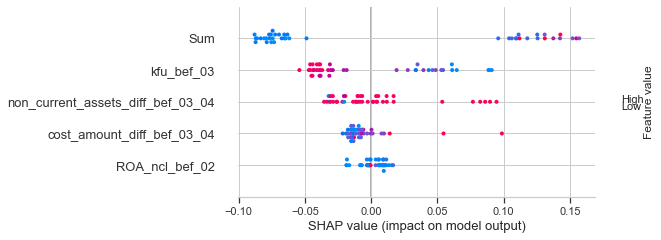

In [132]:
explainer_forest = shap.TreeExplainer(best_forest)
shap_values_forest = explainer_forest.shap_values(xvalid)
shap.summary_plot(shap_values_forest[1], xvalid)

График построен для значений факта ПДЗ, равных 1, т.е. просрочка была.  
По горизонтальной оси отложены значения Шепли, которые показывают как значение признака влияет на предсказание модели.  
По вертикали расположены сами признаки, а цветом обозначены значения этих признаков. Синий цвет и его оттенки - это маленькие значения, красный цвет и его оттенки - это наибольшие значения.  
Из графика видно, что маленькие значения признака "Sum" уменьшают вероятность предсказания в среднем на 0.075. Однако большие значения имееют обратную силу. Причём влияние на предсказание модели лежит в диапазоне от 0.10 до 0.16. Этот признак, как по таблице важности признаков, так и по данному графику, является важным. Напоминим, что это сумма факторных признаков.  
Единичные положительные влияния имеет признак "cost_amount_diff_bef_03_04" (Разница в себестоимости продаж -3 года к -4 от текущего). Основное множество его значений расположено очень близко к нулевой оси, что, в свою очередь означает, мизерное влияние на предсказание модели или полное его отсутствие. Данное подтверждается таблицей важности признаков.  
Аналогичным влиянием должен обладать и признак "ROA_ncl_bef_02" (Рентабельность внеоборотных активов  по данным -2 года от текущего), потому что диапазон изменения значений Шепли составляет от -0.02 до 0.02. Однако наличие резко выделяющихся значений, т.е. выбросов, делает этот признак одним неважных признаков.  
Разброс значений Шепли признака "kfu_bef_03" (Коэффициент финансовой устойчивости по данным -3 года от текущего) довольно-таки большой. Влияние этого признака на предсказания модели нельзя не учитывать. Из графика видно, что большие значения уменьшают вероятность, а малые значения наоборот - повышают предсказания, причём в некоторых случаях - два двух точек- почти аж до 0.10. Однако такие значения вполне могут быть выбросами, что, соответственно, отразится в таблице важности признаков.  
Признак "non_current_assets_diff_bef_03_04" (Изменение внеоборотных активов -3 года к -4 от текущего) по таблице важности занимает второе место. По графику можем заметить, что большая часть значений этого признака плохо влияет на предсказания модели. Примечательным фактом является и то, что почти все значения наибольшие. Данный признак необходимо рассмотреть совместно с признаком "Sum".

Определим все возможные комбинации признаков.

In [133]:
columns_for_bagging = list(combinations(list(X), 2))
columns_for_bagging

[('Sum', 'ROA_ncl_bef_02'),
 ('Sum', 'kfu_bef_03'),
 ('Sum', 'non_current_assets_diff_bef_03_04'),
 ('Sum', 'cost_amount_diff_bef_03_04'),
 ('ROA_ncl_bef_02', 'kfu_bef_03'),
 ('ROA_ncl_bef_02', 'non_current_assets_diff_bef_03_04'),
 ('ROA_ncl_bef_02', 'cost_amount_diff_bef_03_04'),
 ('kfu_bef_03', 'non_current_assets_diff_bef_03_04'),
 ('kfu_bef_03', 'cost_amount_diff_bef_03_04'),
 ('non_current_assets_diff_bef_03_04', 'cost_amount_diff_bef_03_04')]

Обучим столько моделей, сколько получилось пар признаков.

In [136]:
np.random.seed(SEED)

columns_for_bagging = list(combinations(list(X), 2))

x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=42, shuffle=True, random_state=SEED)

clf = RandomForestClassifier(n_jobs=-1, random_state=SEED, warm_start=True)

clfs = []
for i in tqdm_notebook(range(len(columns_for_bagging))):
    
    train = x_train.loc[:, columns_for_bagging[i]]
    valid = x_valid.loc[:, columns_for_bagging[i]]
    
    grid = RandomizedSearchCV(clf, param_distributions=params, return_train_score=False,
                              scoring=make_scorer(roc_auc_score), cv=5, n_jobs=1, refit=True, verbose=0, n_iter=100)
    grid.fit(train, y_train)
    print('ROC-AUC на обучении:', grid.best_score_)
    
    best_clf = grid.best_estimator_
    clfs.append(best_clf)
    
    predicted = best_clf.predict(valid)
    get_scores(y_valid, predicted, metrics=metrics)
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

ROC-AUC на обучении: 0.6284905660377358
accuracy_score: 0.7380952380952381
roc_auc_score: 0.7334096109839817

ROC-AUC на обучении: 0.6317924528301886
accuracy_score: 0.7142857142857143
roc_auc_score: 0.7162471395881007

ROC-AUC на обучении: 0.6431603773584906
accuracy_score: 0.7619047619047619
roc_auc_score: 0.7688787185354691

ROC-AUC на обучении: 0.6462264150943395
accuracy_score: 0.7142857142857143
roc_auc_score: 0.711670480549199

ROC-AUC на обучении: 0.5360849056603774
accuracy_score: 0.5238095238095238
roc_auc_score: 0.5652173913043479

ROC-AUC на обучении: 0.5141509433962264
accuracy_score: 0.6190476190476191
roc_auc_score: 0.6155606407322655

ROC-AUC на обучении: 0.5493867924528302
accuracy_score: 0.6428571428571429
roc_auc_score: 0.6464530892448512

ROC-AUC на обучении: 0.5511792452830189
accuracy_score: 0.5952380952380952
roc_auc_score: 0.5938215102974829

ROC-AUC на обучении: 0.5801415094339623
accuracy_score: 0.5238095238095238
roc_auc_score: 0.5194508009153318

ROC-AUC на 

Наилучшая модель была получена для третьей пары признаков: ('Sum', 'non_current_assets_diff_bef_03_04').  
ROC-AUC на обучении составил 0.64316, а на тесте - 0.76888. Значение accurcy составило 76.19048%.

Сохраним полученную модель.

In [137]:
with open('final_model.pkl', 'wb') as file:
    pickle.dump(clfs[2], file)

Посмотрим на важность признаков, а также на график влияния этих признаков на предсказания модели.

In [138]:
columns = ['Sum', 'non_current_assets_diff_bef_03_04']

In [139]:
valid_df = x_valid.loc[:, columns]

In [140]:
perm = PermutationImportance(clfs[2], random_state=SEED).fit(valid_df, y_valid)
eli5.show_weights(perm, feature_names=list(valid_df))

Weight,Feature
0.2238 ± 0.1227,Sum
0.0571 ± 0.0774,non_current_assets_diff_bef_03_04


Как видно из таблицы комбинация этих признаков позволила повысить важность каждого признака по отдельности.

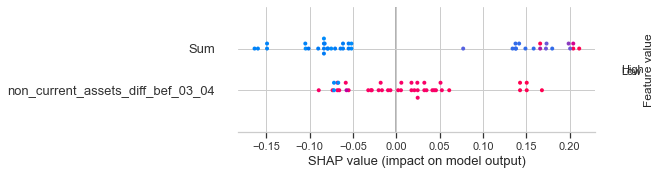

In [141]:
explainer = shap.TreeExplainer(clfs[2])
shap_values = explainer.shap_values(valid_df)
shap.summary_plot(shap_values[1], valid_df)

Для повышения точности предсказаний ПДЗ необходимо, чтобы сумма факторных признаков (признак "Sum") рассчитывалсь для признаков без пропусков. Это позволит получить более релевантные данные по этому признаку, а как следствие повысит влияние этого фактора на предсказания модели.  
Признак "non_current_assets_diff_bef_03_04" (Изменение внеоборотных активов -3 года к -4 от текущего) отлично комбинирует с признаком "Sum". Высокие значения этого прзнака в правой части перекрывают низкие значения признака "Sum" в левой части графика,а как следствие значения Шепли могут имееть неотрицательные значения, что, в свою очередь, положительно сказывается на предсказаниях модели. Значения Шепли части основной массы точек "non_current_assets_diff_bef_03_04" могут быть перекрыты значениями Шепли признака "Sum" в правой части графика.

<h1>7 Заключение</h1>

В ходе проделанной работы по анализу контрагентов и выявлению факторов просрочки дебеторской задолженности была получена точность предсказаний в 76.19048% на модели случайного леса (метрика roc-auc составила 0.76888). Для предсказаний ПДЗ были использованы только два признака, которые и дали максимальную полученную точность предсказаний:
- сумма факторных признаков;
- изменение внеоборотных активов -3 года к -4 от текущего.  

Было выявлено, что малые значения суммы факторных признаков, обусловленные наличием большого числа пропусков в данных, довольно-таки негативно влияют на предсказание модели. Однако высокие значения, т.е. такие, которые аккумулируют значения большого числа факторных признаков, положительно сказываются на выход скоринговой модели.  

Признак "изменение внеоборотных активов -3 года к -4 от текущего" был выбран, потому что именно он занимает вторую строчку в таблице важности признаков. Взаимодействие данного признака с признаком, описанным выше, дают такую комбинацию, которая позволила получить указанную выше точность.  

Однако не отрицаем, что существование других признаков, которые не были отражены в данных, позволит получить более сильную синергию, чем представленная в работа.  

Для качественной оценки контрагента необходимо:
1. В идеале - стандартная бухгалтерская отчетность за последние 3 года с пояснениями (лучше за 4). Если такой возможности нет, минимально, к текущим данным, нужны:  

К балансу (Форма 1):
 - Оборотные активы:
      - Деньги и финансовые инструменты;
      - Запасы;

 - Капитал и резервы:
      - Нераспределенная прибыль/убыток;
 
К PL(Форма 2):

 - Начисленные к получению/уплате проценты;
 - Уровень прочих доходов-расходов.

Это нужно для расчета оставшихся коэффициентов, а изменение некоторых показателей лучше отражает операционную деятельность.

2. Данные о товарообороте (выручке) между Северсталью и контрагентом.  


3. Косвенные данные о контрагенте (открытые, бесплатные):
 - Возраст (лет зарегистрирован);
 - Признак "массовости" адреса регистрации;
 - Признак "массовости" учредителя/директора регистрации;
 - Данные о количестве и сумме госконтрактов (если есть);
 - Данные о количестве и сумме судебных делопроизводствах (истец/ответчик).  


4. Косвенные данные о контрагенте (открытые, платные):
 - Данные о средне-списочной численности сотрудников;
 - Данные о средней заработной плате.